# Notebook 05 — Model Comparison, Feature Importance, Interpretation, Business Recommendations

## 05.1 Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import (
    roc_auc_score, average_precision_score, f1_score,
    confusion_matrix, roc_curve, precision_recall_curve
)

RANDOM_STATE = 42
pd.set_option("display.max_columns", 100)


## 05.2 Load data, define X/y, split (stratified)

In [2]:
DATA_PATH = r"C:\Users\farbo\OneDrive\Desktop\churn-analysis\data\telco_churn_clean.csv"
df = pd.read_csv(DATA_PATH)

TARGET_COL = "churn"
X = df.drop(columns=[TARGET_COL])
y = df[TARGET_COL]

# drop ID if present
for col in ["customerid", "customer_id", "id"]:
    if col in X.columns:
        X = X.drop(columns=[col])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE
)

print("Train churn rate:", y_train.mean())
print("Test churn rate:", y_test.mean())
print("X_train shape:", X_train.shape, "X_test shape:", X_test.shape)


Train churn rate: 0.2653532126375577
Test churn rate: 0.2654364797728886
X_train shape: (5634, 19) X_test shape: (1409, 19)


## 05.3 Build preprocessing (same logic as Notebook 03)

In [3]:
numeric_features = X.select_dtypes(include=["int64", "float64"]).columns.tolist()
categorical_features = X.select_dtypes(include=["object"]).columns.tolist()

numeric_pipeline = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_pipeline = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse=False))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_pipeline, numeric_features),
        ("cat", categorical_pipeline, categorical_features)
    ]
)

print("Numeric:", numeric_features)
print("Categorical:", categorical_features[:10], "..." if len(categorical_features) > 10 else "")


Numeric: ['seniorcitizen', 'tenure', 'monthlycharges', 'totalcharges']
Categorical: ['gender', 'partner', 'dependents', 'phoneservice', 'multiplelines', 'internetservice', 'onlinesecurity', 'onlinebackup', 'deviceprotection', 'techsupport'] ...


## 05.4 Define models (LogReg balanced + Random Forest)

In [4]:
logreg_balanced = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", LogisticRegression(max_iter=1000, class_weight="balanced", random_state=RANDOM_STATE))
])

rf_default = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", RandomForestClassifier(
        n_estimators=400,
        random_state=RANDOM_STATE,
        n_jobs=-1
    ))
])

rf_balanced = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", RandomForestClassifier(
        n_estimators=400,
        random_state=RANDOM_STATE,
        n_jobs=-1,
        class_weight="balanced_subsample"
    ))
])


## 05.5 Evaluation helper (consistent metrics + plots)

In [5]:
def evaluate_prob_model(model, X_test, y_test, threshold=0.5, label="Model"):
    probs = model.predict_proba(X_test)[:, 1]
    preds = (probs >= threshold).astype(int)

    roc_auc = roc_auc_score(y_test, probs)
    pr_auc = average_precision_score(y_test, probs)
    f1 = f1_score(y_test, preds)
    cm = confusion_matrix(y_test, preds)

    print(f"=== {label} ===")
    print(f"ROC-AUC: {roc_auc:.4f}")
    print(f"PR-AUC:  {pr_auc:.4f}")
    print(f"F1@{threshold:.2f}: {f1:.4f}")
    print("Confusion Matrix:\n", cm)
    print()
    return probs, {"roc_auc": roc_auc, "pr_auc": pr_auc, "f1": f1, "cm": cm}


## 05.6 Fit + evaluate all models (test set)

In [6]:
logreg_balanced.fit(X_train, y_train)
rf_default.fit(X_train, y_train)
rf_balanced.fit(X_train, y_train)

probs_lr, m_lr = evaluate_prob_model(logreg_balanced, X_test, y_test, label="LogReg (balanced)")
probs_rf, m_rf = evaluate_prob_model(rf_default, X_test, y_test, label="RandomForest (default)")
probs_rfb, m_rfb = evaluate_prob_model(rf_balanced, X_test, y_test, label="RandomForest (balanced_subsample)")


d:\Anaconda\Instalation\Lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
d:\Anaconda\Instalation\Lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
d:\Anaconda\Instalation\Lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


=== LogReg (balanced) ===
ROC-AUC: 0.8417
PR-AUC:  0.6328
F1@0.50: 0.6136
Confusion Matrix:
 [[747 288]
 [ 81 293]]

=== RandomForest (default) ===
ROC-AUC: 0.8205
PR-AUC:  0.6123
F1@0.50: 0.5455
Confusion Matrix:
 [[921 114]
 [191 183]]

=== RandomForest (balanced_subsample) ===
ROC-AUC: 0.8223
PR-AUC:  0.6148
F1@0.50: 0.5301
Confusion Matrix:
 [[921 114]
 [198 176]]



## 05.7 Compare ROC + PR curves

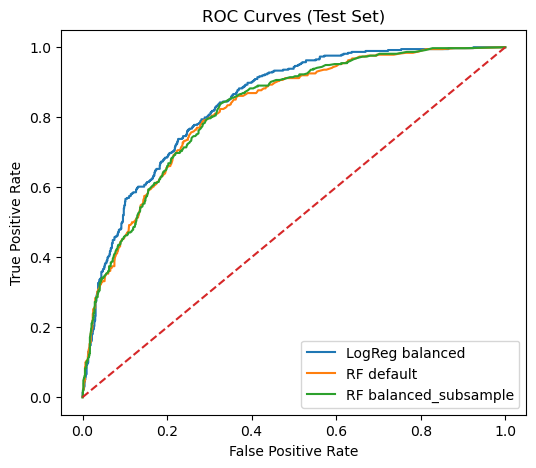

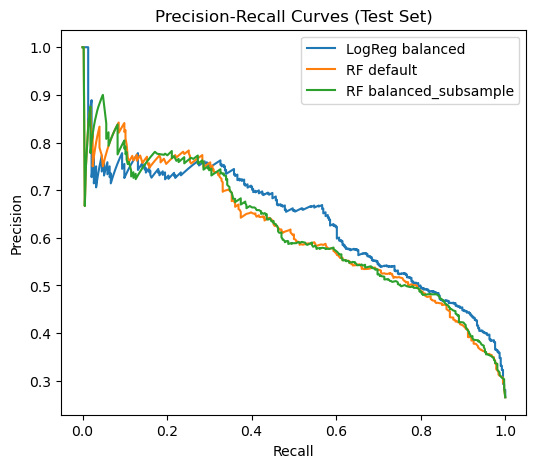

In [7]:
# ROC
fpr_lr, tpr_lr, _ = roc_curve(y_test, probs_lr)
fpr_rf, tpr_rf, _ = roc_curve(y_test, probs_rf)
fpr_rfb, tpr_rfb, _ = roc_curve(y_test, probs_rfb)

plt.figure(figsize=(6,5))
plt.plot(fpr_lr, tpr_lr, label="LogReg balanced")
plt.plot(fpr_rf, tpr_rf, label="RF default")
plt.plot(fpr_rfb, tpr_rfb, label="RF balanced_subsample")
plt.plot([0,1],[0,1],'--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves (Test Set)")
plt.legend()
plt.show()

# PR
prec_lr, rec_lr, _ = precision_recall_curve(y_test, probs_lr)
prec_rf, rec_rf, _ = precision_recall_curve(y_test, probs_rf)
prec_rfb, rec_rfb, _ = precision_recall_curve(y_test, probs_rfb)

plt.figure(figsize=(6,5))
plt.plot(rec_lr, prec_lr, label="LogReg balanced")
plt.plot(rec_rf, prec_rf, label="RF default")
plt.plot(rec_rfb, prec_rfb, label="RF balanced_subsample")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curves (Test Set)")
plt.legend()
plt.show()


## 05.8 Cross-validation (StratifiedKFold) — mean ± std ROC-AUC

In [8]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

def cv_roc_auc(model, X_train, y_train, label):
    scores = cross_val_score(model, X_train, y_train, cv=skf, scoring="roc_auc")
    print(f"{label} CV ROC-AUC: {scores.mean():.4f} ± {scores.std():.4f}")
    return scores

scores_lr = cv_roc_auc(logreg_balanced, X_train, y_train, "LogReg (balanced)")
scores_rf = cv_roc_auc(rf_default, X_train, y_train, "RF (default)")
scores_rfb = cv_roc_auc(rf_balanced, X_train, y_train, "RF (balanced_subsample)")


d:\Anaconda\Instalation\Lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
d:\Anaconda\Instalation\Lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
d:\Anaconda\Instalation\Lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
d:\Anaconda\Instalation\Lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `spa

LogReg (balanced) CV ROC-AUC: 0.8460 ± 0.0124


d:\Anaconda\Instalation\Lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
d:\Anaconda\Instalation\Lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
d:\Anaconda\Instalation\Lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
d:\Anaconda\Instalation\Lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `spa

RF (default) CV ROC-AUC: 0.8203 ± 0.0123


d:\Anaconda\Instalation\Lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
d:\Anaconda\Instalation\Lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
d:\Anaconda\Instalation\Lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
d:\Anaconda\Instalation\Lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `spa

RF (balanced_subsample) CV ROC-AUC: 0.8219 ± 0.0104


## 05.9 Threshold tuning (pick a threshold based on business goals)

In [9]:
def sweep_thresholds(probs, y_true, thresholds=(0.2, 0.3, 0.4, 0.5, 0.6)):
    rows = []
    for t in thresholds:
        preds = (probs >= t).astype(int)
        rows.append({
            "threshold": t,
            "f1": f1_score(y_true, preds),
            "roc_auc": roc_auc_score(y_true, probs),
            "pr_auc": average_precision_score(y_true, probs),
            "tn_fp_fn_tp": confusion_matrix(y_true, preds).ravel()
        })
    return pd.DataFrame(rows)

threshold_table_lr = sweep_thresholds(probs_lr, y_test)
threshold_table_lr


,threshold,f1,roc_auc,pr_auc,tn_fp_fn_tp
0,0.2,0.553846,0.84166,0.632792,"[469, 566, 14, 360]"
1,0.3,0.587140,0.84166,0.632792,"[574, 461, 27, 347]"
2,0.4,0.606174,0.84166,0.632792,"[664, 371, 50, 324]"
3,0.5,0.613613,0.84166,0.632792,"[747, 288, 81, 293]"
4,0.6,0.611819,0.84166,0.632792,"[810, 225, 110, 264]"


In [10]:
threshold_table_rf = sweep_thresholds(probs_rf, y_test)
threshold_table_rfb = sweep_thresholds(probs_rfb, y_test)

threshold_table_rf, threshold_table_rfb


(   threshold        f1   roc_auc    pr_auc           tn_fp_fn_tp
 0        0.2  0.596190  0.820469  0.612281   [672, 363, 61, 313]
 1        0.3  0.609183  0.820469  0.612281  [788, 247, 102, 272]
 2        0.4  0.582147  0.820469  0.612281  [861, 174, 149, 225]
 3        0.5  0.545455  0.820469  0.612281  [921, 114, 191, 183]
 4        0.6  0.478114  0.820469  0.612281   [957, 78, 232, 142],
    threshold        f1   roc_auc    pr_auc           tn_fp_fn_tp
 0        0.2  0.606526  0.822274  0.614819   [683, 352, 58, 316]
 1        0.3  0.599319  0.822274  0.614819  [792, 243, 110, 264]
 2        0.4  0.584980  0.822274  0.614819  [872, 163, 152, 222]
 3        0.5  0.530120  0.822274  0.614819  [921, 114, 198, 176]
 4        0.6  0.485470  0.822274  0.614819   [966, 69, 232, 142])

## 05.10 Feature importance + interpretation (Random Forest)

In [11]:
# Fit preprocessor alone to get feature names
preprocessor.fit(X_train)

# Build feature names
feature_names = []
feature_names.extend(numeric_features)

ohe = preprocessor.named_transformers_["cat"]["onehot"]
cat_feature_names = ohe.get_feature_names_out(categorical_features)
feature_names.extend(cat_feature_names)

len(feature_names)


d:\Anaconda\Instalation\Lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


45

In [12]:
rf_model = rf_default.named_steps["model"]
importances = rf_model.feature_importances_

fi = pd.DataFrame({
    "feature": feature_names,
    "importance": importances
}).sort_values("importance", ascending=False)

fi.head(20)


,feature,importance
3,totalcharges,0.158208
1,tenure,0.141457
2,monthlycharges,0.137356
36,contract_Month-to-month,0.053835
18,onlinesecurity_No,0.032370
43,paymentmethod_Electronic check,0.029438
27,techsupport_No,0.028443
16,internetservice_Fiber optic,0.025823
0,seniorcitizen,0.019336
4,gender_Female,0.017916


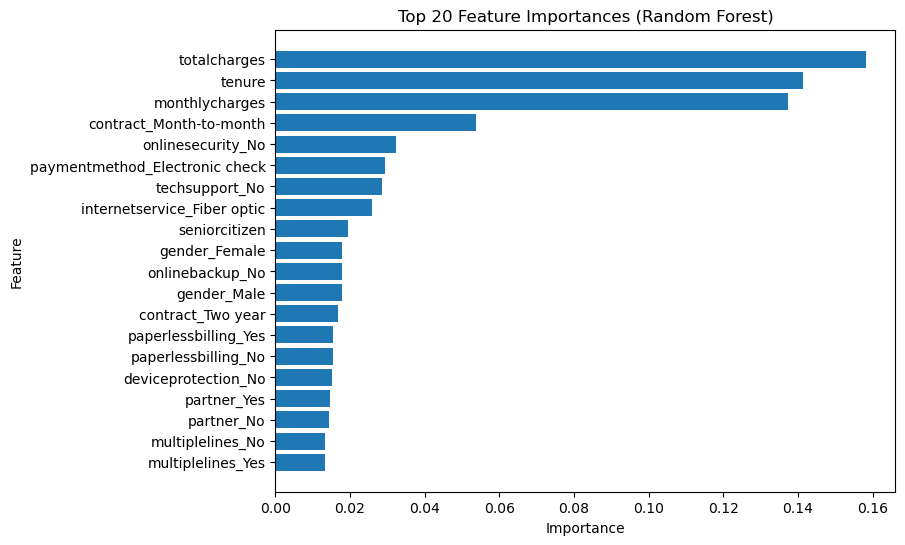

In [13]:
top_n = 20
fi_top = fi.head(top_n).iloc[::-1]  # reverse for nicer horizontal plot

plt.figure(figsize=(8,6))
plt.barh(fi_top["feature"], fi_top["importance"])
plt.title(f"Top {top_n} Feature Importances (Random Forest)")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()


## 05.11 Interpretation notes

### Model Interpretation (Key Drivers)

From feature importance and EDA, churn risk is strongly associated with:

- **Contract type:** Month-to-month customers show higher churn risk than 1–2 year contracts.
- **Tenure:** Newer customers are more likely to churn, indicating early lifecycle risk.
- **Monthly charges:** Higher monthly cost correlates with churn, suggesting price sensitivity.
- **Payment method:** Electronic check users show elevated churn; auto-pay is more stable.
- **Value-added services:** Lack of Tech Support / Online Security is linked to churn, implying higher dissatisfaction or fewer switching costs.


## Final Business Recommendations

## Business Recommendations (Actionable)

1) **Target month-to-month customers with contract upgrade offers**
   - Offer 12/24-month discounts or bundle incentives.
   - Prioritize high-risk month-to-month customers with high monthly charges.

2) **Improve onboarding for new customers (0–6 months tenure)**
   - Launch a “first 90 days” retention program: setup help, check-ins, service optimization.
   - Trigger proactive outreach when early usage/support signals suggest friction.

3) **Reduce churn among high monthly charge customers via plan optimization**
   - Identify customers paying above a threshold and recommend cheaper plans or loyalty discounts.
   - Bundle services (internet + add-ons) to increase perceived value.

4) **Shift customers from electronic check to auto-pay**
   - Provide small monthly credits for switching to bank transfer/credit card autopay.
   - Reduce payment friction and improve billing experience.

5) **Bundle and promote sticky value-added services (Tech Support / Security)**
   - Offer free trials or discounted add-ons for customers flagged at-risk.
   - Position add-ons as “peace of mind” features to reduce switching and dissatisfaction.


## 05.12 Model choice summary

## Final Model Selection

- Logistic Regression provides strong performance with high interpretability.
- Random Forest may improve performance by modeling non-linear relationships, but is less interpretable.
- Final selection should balance:
  - performance (ROC-AUC / PR-AUC / F1)
  - stability (cross-validation std)
  - interpretability (business adoption)


## 05.13 Save the final chosen model

In [15]:
import joblib, os

MODEL_OUT = r"C:\Users\farbo\OneDrive\Desktop\churn-analysis\models\churn_model.pkl"
os.makedirs(os.path.dirname(MODEL_OUT), exist_ok=True)

# Example: save rf_balanced; switch to logreg_balanced if you choose it
best_model = logreg_balanced
best_model.fit(X_train, y_train)

joblib.dump(best_model, MODEL_OUT)
print("Saved model to:", MODEL_OUT)


Saved model to: C:\Users\farbo\OneDrive\Desktop\churn-analysis\models\churn_model.pkl


d:\Anaconda\Instalation\Lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [16]:
COLS_OUT = r"C:\Users\farbo\OneDrive\Desktop\churn-analysis\models\model_columns.json"
import json, os
os.makedirs(os.path.dirname(COLS_OUT), exist_ok=True)

with open(COLS_OUT, "w") as f:
    json.dump(list(X.columns), f)

print("Saved columns to:", COLS_OUT)


Saved columns to: C:\Users\farbo\OneDrive\Desktop\churn-analysis\models\model_columns.json
